# Training NN models:

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd
from sklearn.cluster import MiniBatchKMeans
import joblib
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint
from DataGenerator import DataGenerator_Sup
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


Get a list of all files:

In [2]:
Ad_folder = '../Data/audio_ads' # positive samples location
Music_folder = '../Data/Music'  # negative samples (music) location
Podcast_folder = '../Data/pod'  # negative samples (podcasts) location

pos_files = []
for r,d,f in os.walk(Ad_folder):
    for filename in f:
        if '.mp3' in filename:
            pos_files.append(os.path.join(Ad_folder,filename))

music_files = []
for r,d,f in os.walk(Music_folder):
    for filename in f:
        if '.mp3' or '.au' in filename:
            music_files.append(os.path.join(r,filename))

podcast_files = []
for r,d,f in os.walk(Podcast_folder):
    for filename in f:
        if '.wav' in filename:
            podcast_files.append(os.path.join(r,filename))


How many mp3 files do we have?

In [3]:
neg_files = music_files + podcast_files
n_pos_files = len(pos_files)
n_neg_files = len(neg_files)

print('We have ' + str(n_pos_files) + ' positive examples')
print('We have ' + str(len(music_files)) + ' music examples')
print('We have ' + str(len(podcast_files)) + ' podcast examples')

music_duration = 30/60.0 # duration of files in minutes
podcast_duration = 12/60.0 # duration of files in minutes
ads_duration = 30/60.0 # average duration of ad files in minutes

pos_minutes = round(ads_duration*n_pos_files,2)
neg_minutes = round(music_duration*len(music_files) + podcast_duration*len(podcast_files),2)
pos_fraction = str(round(neg_minutes/pos_minutes,2)) # the fraction of positives to take for balancing
print('--------------------------------')
print('In total, ' + str(pos_minutes) + ' minutes of positive and ' + str(neg_minutes) + ' minutes of negative')

We have 2303 positive examples
We have 1023 music examples
We have 0 podcast examples
--------------------------------
In total, 1151.5 minutes of positive and 511.5 minutes of negative


### Define utility functions:

In [4]:
def create_model(n_features):
    '''Create a model obejct with an input of length n_features'''
    model = Sequential() # create a model instance

    #add model layers
    model.add(Dense(256, activation = 'relu', input_shape=(n_features,)))
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(1, activation = 'sigmoid'))
    
    model.summary()
    return model

In [5]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

### Create data generators:

#### Decide which part of the data to use and how data will be distributed:

In [6]:
minutes2use = 200 # total minutes to use for training and testing
train_fraction = 0.9 # fraction of the data to train on

pos_minutes2use = int(minutes2use/2.0)
neg_minutes2use = int(minutes2use/2.0)

music_minutes2use = (neg_minutes2use/2)*2
podcast_minutes2use = (neg_minutes2use/2)*0
assert music_minutes2use + podcast_minutes2use == neg_minutes2use, 'music + podcast != neg'

# calculate train and test minutes splitting
# train
pos_train_minutes = round(train_fraction*pos_minutes2use, 2) # number of pos audio training minutes
music_train_minutes = round(train_fraction*music_minutes2use, 2) # number of minutes for music training
podcast_train_minutes = round(train_fraction*podcast_minutes2use, 2) # number of minutes for podcast training
# test
pos_test_minutes = pos_minutes2use - pos_train_minutes
music_test_minutes = music_minutes2use - music_train_minutes
if podcast_minutes2use:
    podcast_test_minutes = podcast_minutes2use - podcast_train_minutes
else:
    podcast_test_minutes = 0

print('Using ' + str(pos_train_minutes) + ' minutes of positives for training and '
      + str(pos_test_minutes) + ' for testing')
print('Using ' + str(music_train_minutes) + ' minutes of music and ' 
      + str(podcast_train_minutes) +' minutes of podcasts for training')
print('Using ' + str(music_test_minutes) + ' minutes of music and ' 
      + str(podcast_test_minutes) +' minutes of podcasts for testing')

# calculate number of files
# train
n_music_train_files = int(music_train_minutes/music_duration)
n_podcast_train_files = int(podcast_train_minutes/podcast_duration)
n_pos_train_files = int(pos_train_minutes/ads_duration)
# test
n_music_test_files = int(music_test_minutes/music_duration)
n_podcast_test_files = int(podcast_test_minutes/podcast_duration)
n_pos_test_files = int(pos_test_minutes/ads_duration)
print('---------------------------------------------------------------')
print('This translates into:')
print( str(n_music_train_files) + ' files of music' + ' and ' 
      + str(n_podcast_train_files) + ' files of podcasts for training')
print( str(n_music_test_files) + ' files of music' + ' and ' 
      + str(n_podcast_test_files) + ' files of podcasts for testing')
print(str(n_pos_train_files) + ' poitive files for training')
print(str(n_pos_test_files) + ' poitive files for testing')

assert len(music_files) >= n_music_train_files + \
n_music_test_files, 'There are not enough music files for that!'
assert len(podcast_files) >= n_podcast_train_files + \
n_podcast_test_files, 'There are not enough podcast files for that!'

Using 90.0 minutes of positives for training and 10.0 for testing
Using 90.0 minutes of music and 0.0 minutes of podcasts for training
Using 10.0 minutes of music and 0 minutes of podcasts for testing
---------------------------------------------------------------
This translates into:
180 files of music and 0 files of podcasts for training
20 files of music and 0 files of podcasts for testing
180 poitive files for training
20 poitive files for testing


#### Create a generator based on the above:

In [7]:
train_files = [] # a list of training files 
test_files = [] # a list of test files 

# shuffle files
np.random.shuffle(pos_files)
np.random.shuffle(music_files)
np.random.shuffle(podcast_files)

'''Collect a balanced list of files + add labels'''
# Training list
for f in pos_files[:n_pos_train_files]:
    train_files.append([f,1])
for f in music_files[:n_music_train_files]:
    train_files.append([f,0])
for f in podcast_files[:n_podcast_train_files]:
    train_files.append([f,0])

# Test list
for f in pos_files[n_pos_train_files:n_pos_train_files + n_pos_test_files]:
    test_files.append([f,1])
for f in music_files[n_music_train_files:n_music_train_files + n_music_test_files]:
    test_files.append([f,0])
for f in podcast_files[n_podcast_train_files:n_podcast_train_files + n_podcast_test_files]:
    test_files.append([f,0])

train_generator = DataGenerator_Sup(train_files, dataset='train')
test_generator = DataGenerator_Sup(test_files, dataset='test')

Check generators:

In [24]:
len(train_generator)

36

In [25]:
len(test_generator)

4

In [26]:
if 1:
    X, Y = train_generator.__getitem__(3) # get item
    print(X.shape)
    print(Y.shape)
    print('Positive example fraction in batch is ' + str((sum(Y == 1)/Y.shape[0])[0]))

(127, 1690)
(127, 1)
Positive example fraction in batch is 0.44881889763779526


### Train NN model:

Create and compile model:

In [8]:
num_features = 1690
model = create_model(num_features)
filepath = 'models/weights_1690_256_64_1_temp1.hdf5'
checkpoint = ModelCheckpoint(filepath)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               432896    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 449,409
Trainable params: 449,409
Non-trainable params: 0
_________________________________________________________________


Train model:

In [28]:
H = model.fit_generator(generator = train_generator, epochs = 6, callbacks = [checkpoint])

Epoch 1/6
36/36 [==============================] - 468s 13s/step - loss: 0.3797 - acc: 0.8340
Epoch 2/6
36/36 [==============================] - 442s 12s/step - loss: 0.2601 - acc: 0.9019
Epoch 3/6
36/36 [==============================] - 415s 12s/step - loss: 0.2054 - acc: 0.9139
Epoch 4/6
36/36 [==============================] - 455s 13s/step - loss: 0.1530 - acc: 0.9414
Epoch 5/6
36/36 [==============================] - 459s 13s/step - loss: 0.1584 - acc: 0.9408
Epoch 6/6
36/36 [==============================] - 461s 13s/step - loss: 0.1123 - acc: 0.9676


Text(0.5, 0, 'epoch')

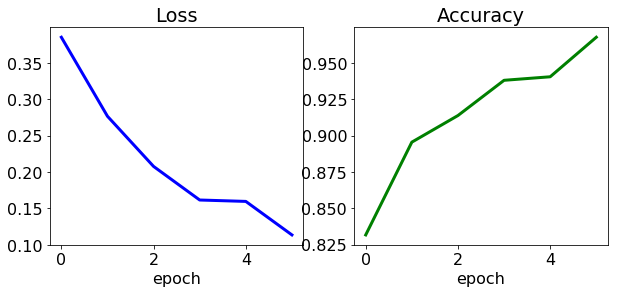

In [29]:
plt.rcParams.update({'font.size': 16})
plt.figure(figsize= (10,4))
plt.subplot(1,2,1)
plt.plot(H.history['loss'], linewidth=3, color = 'b')
plt.title('Loss')
plt.xlabel('epoch')

plt.subplot(1,2,2)
plt.plot(H.history['acc'], linewidth=3, color = 'g')
plt.title('Accuracy')
plt.xlabel('epoch')

In [ ]:
# Error files:
train_generator.err_files

### Check Accuracy:

In [9]:
filepath = 'models/weights_1690_256_64_1_temp1.hdf5'
# recreate a model for evaluation
num_features = 1690
eval_model = create_model(num_features)
# load weights
eval_model.load_weights(filepath)
# compile
eval_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 256)               432896    
_________________________________________________________________
dense_5 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 449,409
Trainable params: 449,409
Non-trainable params: 0
_________________________________________________________________


What metrics do we use for evaluation?

In [10]:
eval_model.metrics_names

['loss', 'acc']

How does the model perform on the test?

In [11]:
eval_model.evaluate_generator(generator = test_generator, steps = 5)

[0.3396361237212038, 0.8725868630363214]

Plot confusion matrix:

In [12]:
X,Y = test_generator.__getitem__(2)
Y_pred = eval_model.predict(X)

Confusion matrix, without normalization
[[56  4]
 [20 11]]


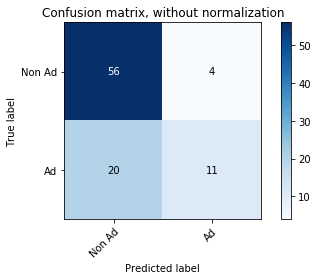

In [13]:
plot_confusion_matrix(Y, Y_pred>0.9, ['Non Ad', 'Ad'])

In [14]:
sum(Y)

array([31])